<a href="https://colab.research.google.com/github/PranavSuresh525/AI-ML-Projects/blob/main/PCB_Classification/PCB_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## All the imports necessary
!pip install opendatasets
!pip install opencv-python
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import shutil
import random
from tqdm import tqdm
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [ ]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct/len(y_pred)
    return acc*100

In [ ]:
## device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
od.download('https://www.kaggle.com/datasets/akhatova/pcb-defects')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Pranav_Suresh2525
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/akhatova/pcb-defects


100%|██████████| 1.88G/1.88G [00:16<00:00, 121MB/s] 


In [ ]:
# ===================== PATHS =====================
DATA_ROOT = './pcb-defects/PCB_DATASET'
IMAGES_ROOT = os.path.join(DATA_ROOT, 'images')
ANN_ROOT = os.path.join(DATA_ROOT, 'Annotations')

# ===================== BUILD XML INDEX =====================
xml_index = {}

for root, _, files in os.walk(ANN_ROOT):
    for f in files:
        if f.lower().endswith('.xml'):
            xml_path = os.path.join(root, f)
            tree = ET.parse(xml_path)
            img_name = tree.getroot().find('filename').text
            xml_index[img_name] = xml_path

print(f"✓ Indexed XMLs: {len(xml_index)}")

# ===================== BUILD DATAFRAME =====================
rows = []

for root, _, files in os.walk(IMAGES_ROOT):
    for img_file in files:
        if not img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        if img_file not in xml_index:
            continue

        xml_path = xml_index[img_file]
        img_path = os.path.join(root, img_file)

        tree = ET.parse(xml_path)
        ann_root = tree.getroot()

        # one row per defect object
        for obj in ann_root.findall("object"):
            label = obj.find("name").text.lower().replace(" ", "_")
            rows.append({
                "filepath": img_path,
                "xmlpath": xml_path,
                "label": label
            })

df = pd.DataFrame(rows)

print(f"✓ Total defect samples: {len(df)}")
print(df.head())

# ===================== TRAIN / VAL / TEST SPLIT =====================
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ===================== DATASET CLASS =====================
class PCBCroppedDataset(Dataset):
    def __init__(self, dataframe, transform=None, patch_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.patch_size = patch_size
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def _get_bbox(self, xml_path, label):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text.lower().replace(" ", "_")
            if name == label:
                b = obj.find("bndbox")
                return (
                    int(b.find("xmin").text),
                    int(b.find("ymin").text),
                    int(b.find("xmax").text),
                    int(b.find("ymax").text),
                )
        return None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        bbox = self._get_bbox(row['xmlpath'], row['label'])

        if bbox:
            xmin, ymin, xmax, ymax = bbox
            cx, cy = (xmin + xmax) // 2, (ymin + ymax) // 2
        else:
            cx, cy = w // 2, h // 2

        half = self.patch_size // 2
        x1, y1 = max(0, cx - half), max(0, cy - half)
        x2, y2 = min(w, cx + half), min(h, cy + half)

        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (self.patch_size, self.patch_size))
        crop = Image.fromarray(crop)

        if self.transform:
            crop = self.transform(crop)

        label_idx = self.class_to_idx[row['label']]
        return crop, label_idx

# ===================== TRANSFORMS =====================
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===================== DATALOADERS =====================
train_ds = PCBCroppedDataset(train_df, train_tfms)
val_ds   = PCBCroppedDataset(val_df, test_tfms)
test_ds  = PCBCroppedDataset(test_df, test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# ===================== VERIFY =====================
images, labels = next(iter(train_loader))
print(images.shape)  # [B, 3, 224, 224]
print(labels.shape)  # [B]


In [ ]:
## Model which can be used but is untrained
class PCB_Model(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 512 → 256
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 256 → 128
        )
        self.conv_block_3=nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 128 → 64
        )
        self.conv_block_4=nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 64 → 32
        )
        self.classifier=nn.Sequential(
          nn.Flatten(),
          nn.Linear(512*32*32, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 256 ),
          nn.ReLU(),
          nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.conv_block_3(x)
        x=self.conv_block_4(x)
        x=self.classifier(x)
        return x

In [ ]:
model=torchvision.models.resnet34(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]


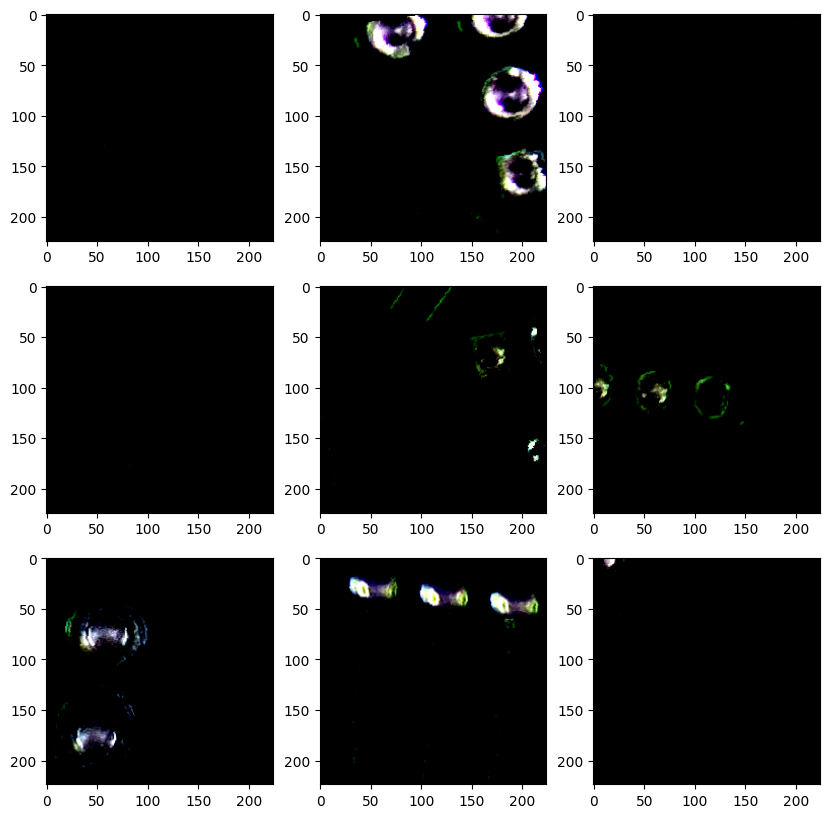

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
epochs=8
for epoch in range(epochs):
  model.train()
  train_loss=0.0
  for batch_idx, (X, y) in enumerate(train_loader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X)
    loss=loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(batch_idx%40==0):
            print(f"Looked at{batch_idx*len(X)}/{len(train_loader.dataset)} samples")
  train_loss/=len(train_loader)
  test_loss=0.0
  test_acc=0.0
  model.eval()
  with torch.inference_mode():
    for X,y in test_loader:
      X,y= X.to(device),y.to(device)
      test_pred=model(X)
      test_loss+=loss_fn(test_pred,y).item()
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
  test_loss/=len(test_loader)
  test_acc/=len(test_loader)
  print(
        f"Train loss: {train_loss:.5f} | "
        f"Test loss: {test_loss:.5f} | "
        f"Test acc: {test_acc:.2f}%"
    )

Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 1.46874 | Test loss: 0.83571 | Test acc: 68.12%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.35203 | Test loss: 0.31925 | Test acc: 91.88%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.15161 | Test loss: 0.10385 | Test acc: 96.25%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.10572 | Test loss: 0.29723 | Test acc: 89.38%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.16474 | Test loss: 0.05399 | Test acc: 98.44%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.04580 | Test loss: 0.03092 | Test acc: 99.38%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.02484 | Test loss: 0.00797 | Test acc: 100.00%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.02135 | Test loss: 0.00314 | Test acc: 100.00%
Looked at0/2362 samples
Looked at1280/2362 samples
Train loss: 0.04321 | Test loss: 0.00342 | Test acc: 100.00

In [ ]:
# Define path to save model
SAVE_PATH = './pcb_model.pth'

# Save the state_dict
torch.save(model.state_dict(), SAVE_PATH)
print(f"Model state_dict saved at {SAVE_PATH}")


Model state_dict saved at ./pcb_model.pth
